# Effect of adaptation

In this notebook, we measure different state statistics as a function of a changing adaptation strength paramter `b` (Fig. 5). Later, we run the sleep model with its original parameters and measure the ISI distribution of local and global oscillations (Fig. 4 f)

In [1]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "notebooks":
    os.chdir('..')
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2   

In [2]:
%aimport

Modules to reload:


Modules to skip:



In [3]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    import sys
    !{sys.executable} -m pip install matplotlib seaborn
    import matplotlib.pyplot as plt
    
import numpy as np
import logging 

from neurolib.models.aln import ALNModel
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.evolution import Evolution
import neurolib.utils.functions as func
import neurolib.utils.devutils as du
import neurolib.utils.pypetUtils as pu

import neurolib.optimize.evolution.deapUtils as deapUtils
import neurolib.utils.brainplot as bp

import scipy.signal

from neurolib.optimize.exploration import BoxSearch

from neurolib.utils.loadData import Dataset
ds = Dataset("gw_big")

# a nice color map
plt.rcParams['image.cmap'] = 'plasma'

In [5]:
ds = Dataset("gw", fcd=False)
model = ALNModel(Cmat = ds.Cmat, Dmat = ds.Dmat)
model.params['dt'] = 0.1
model.params['duration'] = 1.0 * 60 * 1000 #ms

In [7]:
# Results in /mnt/raid/data/cakan/hdf/experiment-10.0-adaptation-noise.hdf
model.params["mue_ext_mean"] = 3.3202829454334535
model.params["mui_ext_mean"] = 3.682451894176651
model.params["b"] = 3.2021806735984186
model.params["tauA"] = 4765.3385276559875
model.params["sigma_ou"] = 0.36802952978628106
model.params["Ke_gl"] = 265.48075753153

# Adaptation and noise

In [15]:
plt.style.reload_library()
plt.style.use("paper")
plt.rcParams['svg.fonttype'] = 'none'

In [16]:
#parameters = ParameterSpace({"b": np.linspace(2.0, 15.0, 66), "sigma_ou": np.linspace(0.0, 0.5, 6)})
parameters = ParameterSpace({"b": np.linspace(1.0, 6.0, 41), "sigma_ou": np.linspace(0.1, 0.4, 4)})
search = BoxSearch(model, parameters, filename="experiment-10.0-adaptation-noise.hdf")

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `/mnt/raid/data/cakan/hdf/experiment-10.0-adaptation-noise.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
/home/cakan/anaconda/lib/python3.7/site-packages/pypet/parameter.py:884: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(dtype, np.str):
MainProcess root INFO     Number of parameter configurations: 164
MainProcess root INFO     BoxSearch: Environment initialized.


In [17]:
search.run()

In [18]:
pu.getTrajectorynamesInFile("/mnt/raid/data/cakan/hdf/experiment-10.0-adaptation-noise.hdf")

/mnt/antares_raid/home/cakan/projects/neurolib/neurolib/utils/pypetUtils.py:21: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  hdf = h5py.File(filename)


['results-2020-10-27-11H-32M-47S',
 'results-2020-10-27-18H-41M-22S',
 'results-2020-10-27-18H-43M-02S']

In [19]:
#search.loadResults(filename="/mnt/raid/data/cakan/hdf/experiment-10.0-effect-adaptation-noise.hdf", trajectoryName='results-2020-09-29-15H-27M-12S')
search.loadResults(filename="/mnt/raid/data/cakan/hdf/experiment-10.0-adaptation-noise.hdf", trajectoryName='results-2020-10-27-11H-32M-47S')

MainProcess root INFO     Loading results from /mnt/raid/data/cakan/hdf/experiment-10.0-adaptation-noise.hdf
MainProcess root INFO     Analyzing trajectory results-2020-10-27-11H-32M-47S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `/mnt/raid/data/cakan/hdf/experiment-10.0-adaptation-noise.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2020-10-27-11H-32M-47S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Loading all results to `results` dictionary ...
100%|██████████| 486/486 [11:15<00:00,  1.39s/it]
MainProcess root INFO     Aggregating results to `dfResults` ...

In [23]:
def kuramoto_state_transitions(states, skip=1):
    up_transitions = np.diff(states[:, ::skip])>0
    down_transitions = np.diff(states[:, ::skip])<0

    kuramoto_up = kuramoto(up_transitions)
    kuramoto_down = kuramoto(down_transitions)
    return kuramoto_up, kuramoto_down

def kuramoto(events):
    import tqdm
    # fill in event at the end of the timeseries
    events[:, -1] = True
    phases = []
    #logging.info("Determining phases ...")
    for n, ev in enumerate(events):
        maximalist = np.where(ev)[0]
        phases.append([])
        last_event = 0
        for m in maximalist:
            for t in range(last_event, m):
                phi = 2 * np.pi * float(t - last_event) / float(m - last_event)
                phases[n].append(phi)
            last_event = m
        phases[n].append(2 * np.pi)

    #logging.info("Computing Kuramoto order parameter ...")
    # determine kuramoto order paramter
    kuramoto = []
    nTraces = events.shape[0]
    for t in range(events.shape[1]):
        R = 1j * 0
        for n in range(nTraces):
            R += np.exp(1j * phases[n][t])
        R /= nTraces
        kuramoto.append(np.absolute(R))
    return kuramoto

In [27]:
def process_run(output):
    model.outputs[model.default_output] = output
    states = bp.detectSWs(model)
    durations = bp.get_state_lengths(states)
    involvement = bp.get_involvement(states)
    kuramoto_up, kuramoto_down = kuramoto_state_transitions(states, skip=100)
    
    inv = scipy.ndimage.gaussian_filter1d(involvement, 2000)
    peaks25 = scipy.signal.find_peaks(inv, height=0.25, distance=1000)[0]
    peaks50 = scipy.signal.find_peaks(inv, height=0.5, distance=1000)[0]
    peaks75 = scipy.signal.find_peaks(inv, height=0.75, distance=1000)[0]
    peaks = [peaks25, peaks50, peaks75]
    ups, downs = bp.get_state_durations_flat(model, states)
    return states, durations, involvement, kuramoto_up, kuramoto_down, peaks, ups, downs
#process_run(search.results[0]['rates_exc'])

In [28]:
from p_tqdm import p_map
result_list = p_map(process_run, [search.results[i]['rates_exc'] for i in range(len(search.dfResults))])

In [31]:
all_states = [r[0] for r in result_list]
all_durations = [r[1] for r in result_list]
all_involvements = [r[2] for r in result_list]
all_kuramoto_up = [r[3] for r in result_list]
all_kuramoto_down = [r[4] for r in result_list]
all_peaks = [r[5][1] for r in result_list]

all_peaks25 = [r[5][0] for r in result_list]
all_peaks50 = [r[5][1] for r in result_list]
all_peaks75 = [r[5][2] for r in result_list]

all_ups = [r[6] for r in result_list]
all_downs = [r[7] for r in result_list]

In [38]:
import tqdm

for i in tqdm.tqdm(search.dfResults.index):
    model.outputs[model.default_output] = search.results[i]['rates_exc']
    #states = bp.detectSWs(model)
    states = all_states[i]
    #search.dfResults.loc[i, 'states'] = states
    
    search.dfResults.loc[i, 'max_r'] = np.max(search.results[i]['rates_exc'][:, -int(1000/model.params['dt']):])
    
    #ups, downs = bp.get_state_durations_flat(model, states)
    search.dfResults.loc[i, 'up'] = np.mean(all_ups[i])
    search.dfResults.loc[i, 'down'] = np.mean(all_downs[i])
    
    search.dfResults.loc[i, "kur_up"] = np.mean(all_kuramoto_up[i])
    search.dfResults.loc[i, "kur_down"] = np.mean(all_kuramoto_down[i])
    
    search.dfResults.loc[i, "kur_up_std"] = np.std(all_kuramoto_up[i])
    search.dfResults.loc[i, "kur_down_std"] = np.std(all_kuramoto_down[i])    
    
    #peaks = scipy.signal.find_peaks(all_involvements[i], height=0.5, distance=10000)[0]
    search.dfResults.loc[i, 'peaks'] = len(all_peaks[i])    
    
    search.dfResults.loc[i, 'peaks25'] = len(all_peaks25[i])    
    search.dfResults.loc[i, 'peaks50'] = len(all_peaks50[i])    
    search.dfResults.loc[i, 'peaks75'] = len(all_peaks75[i])    

100%|██████████| 486/486 [00:03<00:00, 160.51it/s]


In [42]:
search.dfResults

,b,sigma_ou,t,rates_exc,max_r,up,down,kur_up,kur_down,kur_up_std,kur_down_std,peaks,peaks25,peaks50,peaks75,domfr
0,0.0,0.0,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[0.007345583239542136, 0.006741450902860305, ...",75.421295,59.997775,0.008900,0.999996,1.000000,0.000323,8.456725e-16,0.0,0.0,0.0,0.0,0.033333
1,0.0,0.1,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[0.007345583239542136, 0.006741450902860305, ...",93.769304,59.997689,0.008805,0.999996,1.000000,0.000323,8.456725e-16,0.0,0.0,0.0,0.0,0.033333
2,0.0,0.2,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[0.007345583239542136, 0.006741450902860305, ...",110.224678,59.997557,0.009305,0.999996,1.000000,0.000323,8.456725e-16,0.0,0.0,0.0,0.0,0.033333
3,0.0,0.3,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[0.007345583239542136, 0.006741450902860305, ...",126.294489,59.254517,0.017459,0.999958,1.000000,0.001085,8.456725e-16,0.0,0.0,0.0,0.0,0.033333
4,0.0,0.4,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[0.007345583239542136, 0.006741450902860305, ...",142.157896,57.825448,0.019512,0.999929,1.000000,0.002343,8.456725e-16,0.0,0.0,0.0,0.0,0.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,15.0,0.1,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[0.007345583239542136, 0.006741443677513817, ...",0.058296,0.438477,5.425876,0.999796,0.999029,0.000357,5.789616e-03,9.0,9.0,9.0,9.0,0.166667
482,15.0,0.2,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[0.007345583239542136, 0.006741443677513817, ...",81.344142,0.376433,3.554806,0.998354,0.995716,0.003267,1.215895e-02,14.0,14.0,14.0,14.0,0.233333
483,15.0,0.3,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[0.007345583239542136, 0.006741443677513817, ...",0.034717,0.307808,2.317241,0.979030,0.973724,0.020041,2.465830e-02,26.0,26.0,26.0,26.0,0.366667
484,15.0,0.4,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...","[[0.007345583239542136, 0.006741443677513817, ...",109.501457,0.238539,1.503436,0.873046,0.869893,0.058708,6.608927e-02,30.0,30.0,30.0,30.0,0.500000


# Plotting

In [55]:
# dynamic correlation
def dynamic_correlation(data, return_matrix=False):
    """Returns dynamic correlation of Nxt-dim data.
    From: Beggs and Timme: Being critical of criticality in the brain (2012, Frontiers in Physiology)
    """
    corr_mat = np.zeros((data.shape[0], data.shape[0]))
    for i1 in range(len(data)):
        for i2 in range(i1):
            d1 = data[i1]
            d2 = data[i2]
            dynamic_correlation = np.mean((d1-np.mean(d1)) * (d2-np.mean(d2)))
            corr_mat[i1, i2] = dynamic_correlation
    if return_matrix:
        return corr_mat
    else:
        summed_currelation = np.mean(corr_mat[np.tril_indices(corr_mat.shape[0], k=1)])
        return summed_currelation
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    #return result[result.size/2:]
    return result

# for i in tqdm.tqdm(search.dfResults.index):
#     data = search.results[i]['rates_exc']
#     #dc = dynamic_correlation(data)
#     print(f"{dc}")
#     #search.dfResults.loc[i, 'dynamic_corr'] = dc
    
# #     ac = autocorr(np.mean(data, axis=0)[::1000])
# #     ac /= np.max(ac)
# #     search.dfResults.at[i, 'auto_corr'] = ac
#     peaks = scipy.signal.find_peaks(involvements[i], height=0.5, distance=10000)[0]
#     search.dfResults.loc[i, 'peaks'] = len(peaks)

In [56]:
# helper function
def set_axis_size(w, h, ax=None):
    """ w, h: width, height in inches """
    if not ax:
        ax = plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w) / (r - l)
    figh = float(h) / (t - b)
    ax.figure.set_size_inches(figw, figh)

0.0
0.1
0.2
0.30000000000000004
0.4
0.5


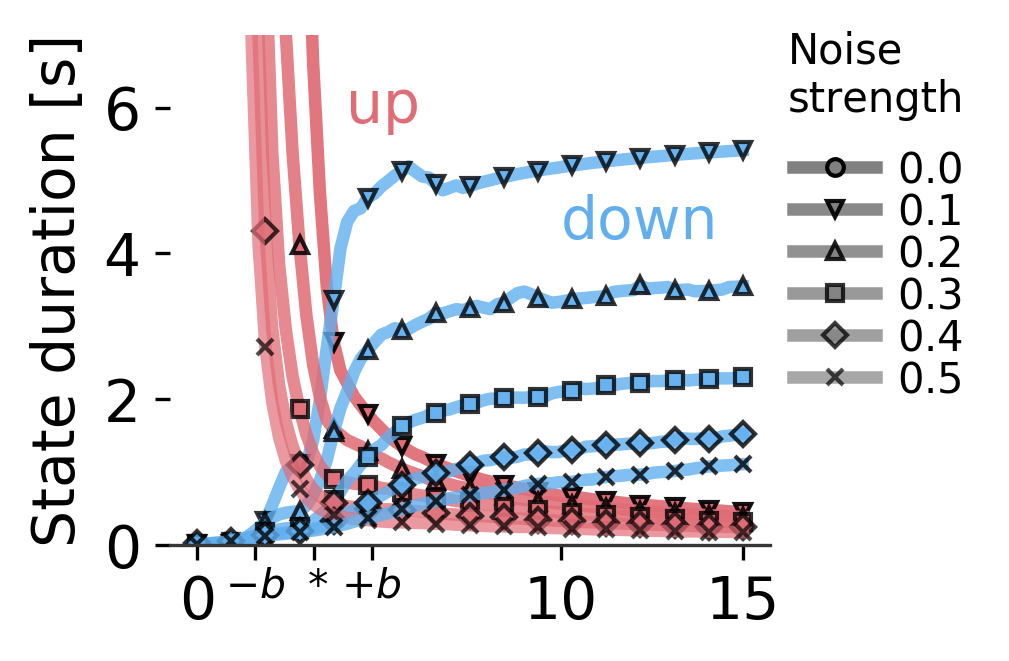

In [57]:
fig, ax = plt.subplots(figsize=(3.5,2.7))
markers = ["o", "v", "^", "s", "D", "x"]
for i, (key, grp) in enumerate(search.dfResults.groupby(['sigma_ou'])):
    print(key)
    ax.plot([], [], c='gray', label="${:0.1f}$".format(key), alpha=0.93**i, marker=markers[i], markevery=5, markersize=4, lw=3, markeredgecolor='k',)
    if key > 0.0:
        color = plt.get_cmap("cool")(int(key*(255.0/0.5)))
        smooth_up = grp['up'].rolling(5, min_periods=1).mean()
        smooth_down = grp['down'].rolling(5, min_periods=1).mean()
        ax.plot(grp['b'], smooth_up, c="C0", marker=markers[i], markevery=5, markersize=4, markeredgecolor='k', lw=3, alpha=0.93**i) #"$\sigma_{ou}="+
        ax.plot(grp['b'], smooth_down, c='C1', marker=markers[i], markevery=5, markersize=4, markeredgecolor='k', lw=3, alpha=0.8)
plt.ylim(0, 7)
#plt.legend(frameon=False, fontsize=8)
#plt.xlabel("Adaptation strength $b$ [pA]")
plt.ylabel("State duration [s]")
plt.text(1.03, 0.85, "Noise\nstrength", fontsize=10, transform=plt.gca().transAxes)
plt.text(4.1, 5.8, "up", fontsize=14,  color='C0')
plt.text(10, 4.2, "down", fontsize=14,  color='C1')
plt.legend(fontsize=10, frameon=False, loc="upper center", bbox_to_anchor=(1.18, 0.85), ncol=1, handletextpad=0.5, labelspacing=0)
plt.xticks([0, 1.6, 3.2, 4.8, 10, 15], [0, "$^{-b}$", "$^*$", "$^{+b}$", 10, 15])
plt.gca().tick_params(axis="both",direction="out",bottom=True,left=True)
plt.tight_layout()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
set_axis_size(2, 1.7)
#plt.savefig("data/figures/RESULTS-adaptation/adaptation_state_durations.pdf", transparent=True)
#plt.savefig("data/figures/RESULTS-adaptation/adaptation_state_durations.svg", transparent=True)

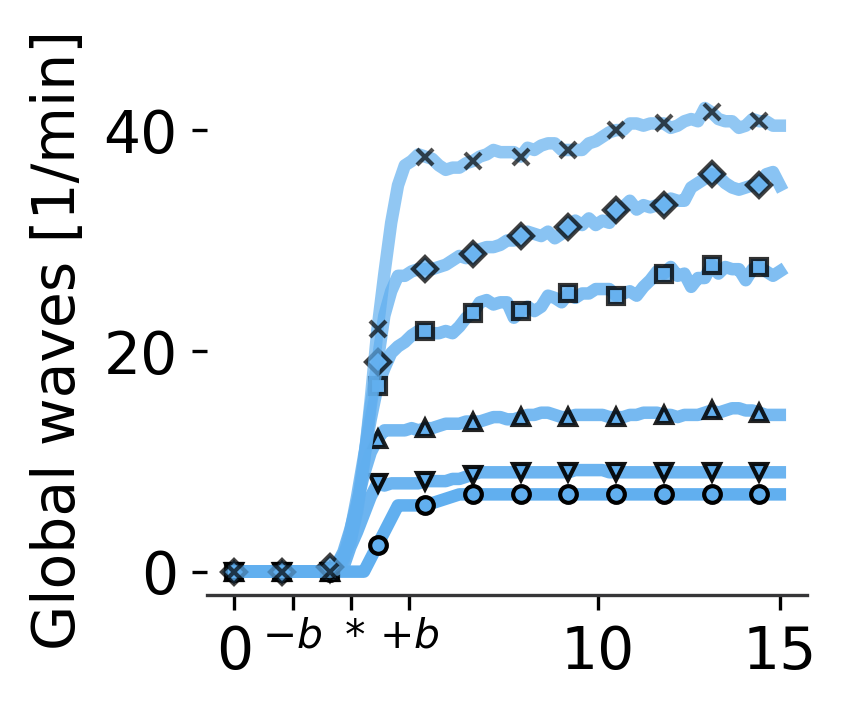

In [220]:
fig, ax = plt.subplots(figsize=(3.5,2.7))
markers = ["o", "v", "^", "s", "D", "x"]
for i, (key, grp) in enumerate(search.dfResults.groupby(['sigma_ou'])):
    color = plt.get_cmap("cool")(int(key*(255.0/0.5)))
    smooth_peaks = grp['peaks50'].rolling(5, min_periods=1).mean()
    ax.plot(grp['b'], smooth_peaks, c="C1", marker=markers[i], markersize=4, markevery=7, markeredgecolor='k', lw=3, label="${:0.1f}$".format(key), alpha=0.93**i) #"$\sigma_{ou}="+
    #ax.plot(grp['b'], grp['down'], c='C1', marker=markers[i], markersize=4, markeredgecolor='k', lw=2)
#plt.ylim(0, 5)
#plt.legend(frameon=False, fontsize=8)
#plt.xlabel("Adaptation strength $b$ [pA]")
plt.ylabel("Global waves [1/min]")
#plt.yticks([])
plt.tight_layout()
plt.xticks([0, 1.6, 3.2, 4.8, 10, 15], [0, "$^{-b}$", "$^*$", "$^{+b}$", 10, 15])
plt.gca().tick_params(axis="both",direction="out",bottom=True,left=True)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.tight_layout()
set_axis_size(2.0, 1.7)
plt.savefig("data/figures/RESULTS-adaptation/adaptation_global_waves.pdf", transparent=True, bbox_inches = "tight")
plt.savefig("data/figures/RESULTS-adaptation/adaptation_global_waves.svg", transparent=True, bbox_inches = "tight")

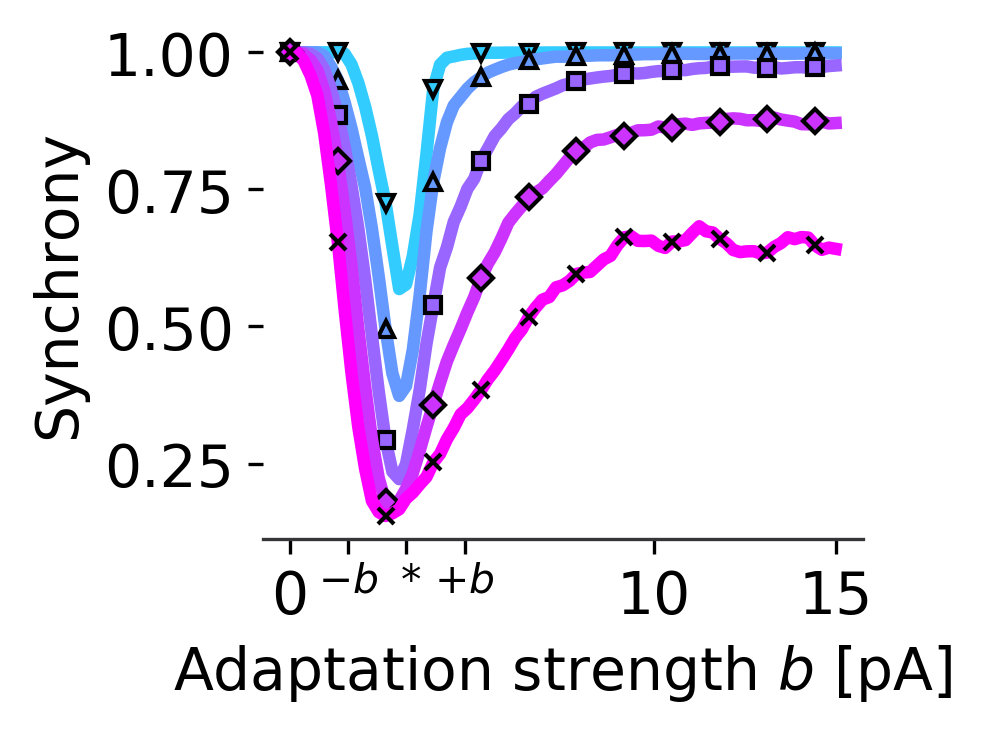

In [122]:
fig, ax = plt.subplots(figsize=(3.5,2.7))
markers = ["o", "v", "^", "s", "D", "x"]
for i, (key, grp) in enumerate(search.dfResults.groupby(['sigma_ou'])):
    color = plt.get_cmap("cool")(int(key*(255.0/0.5)))
    if key > 0:
        smooth_kur = grp['kur_up'].rolling(5, min_periods=1).mean()
        ax.plot(grp['b'], smooth_kur, c=color, marker=markers[i], markersize=4, markevery=7, markeredgecolor='k', lw=3, label="${:0.1f}$".format(key)) #"$\sigma_{ou}="+
        #ax.plot(grp['b'], grp['down'], c='C1', marker=markers[i], markersize=4, markeredgecolor='k', lw=2)
#plt.ylim(0, 5)
#plt.legend(frameon=False, fontsize=8)
plt.xlabel("Adaptation strength $b$ [pA]")
plt.ylabel("Synchrony")
#plt.yticks([])
plt.xticks([0, 1.6, 3.2, 4.8, 10, 15], [0, "$^{-b}$", "$^*$", "$^{+b}$", 10, 15])
plt.gca().tick_params(axis="both",direction="out",bottom=True,left=True)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.tight_layout()
set_axis_size(2, 1.7)
plt.savefig("data/figures/RESULTS-adaptation/adaptation_synchrony.pdf", transparent=True, bbox_inches = "tight")
plt.savefig("data/figures/RESULTS-adaptation/adaptation_synchrony.svg", transparent=True, bbox_inches = "tight")

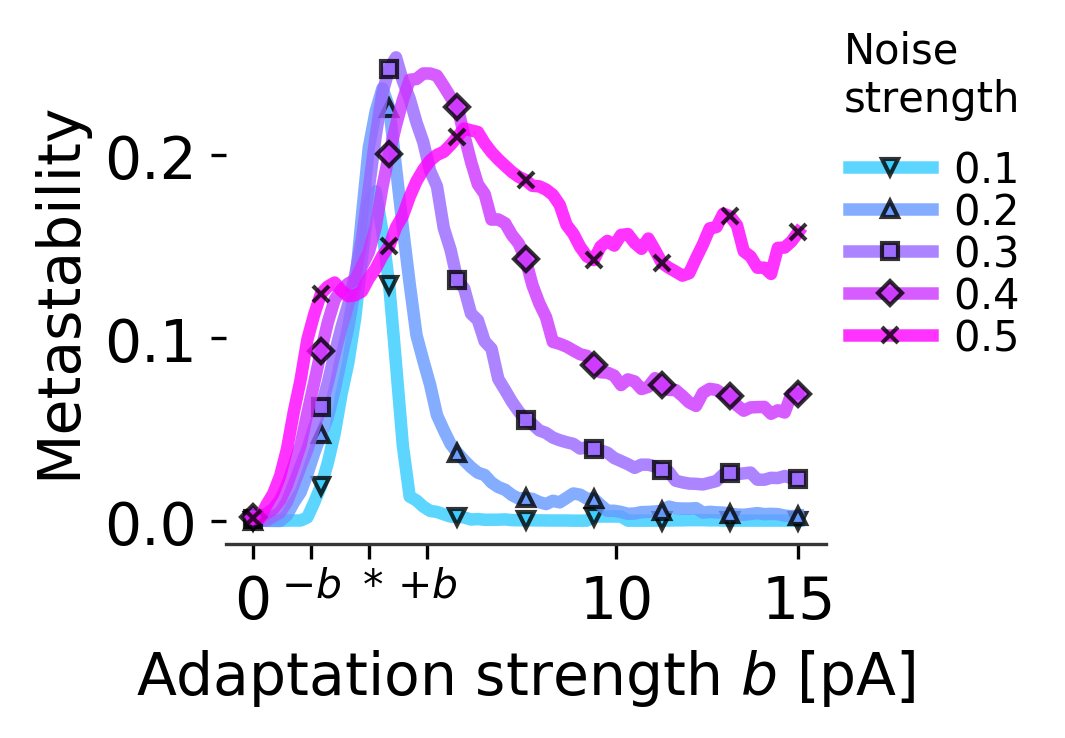

In [131]:
fig, ax = plt.subplots(figsize=(3.5,2.7))
markers = ["o", "v", "^", "s", "D", "x"]
for i, (key, grp) in enumerate(search.dfResults.groupby(['sigma_ou'])):
    if key > 0:
        color = plt.get_cmap("cool")(int(key*(255.0/0.5)))
        smooth_kur_up_std = grp['kur_up_std'].rolling(5, min_periods=1).mean()
        ax.plot(grp['b'], smooth_kur_up_std, c=color, marker=markers[i], markersize=4, markevery=10, alpha=0.8, markeredgecolor='k', lw=3, label="${:0.1f}$".format(key)) #"$\sigma_{ou}="+
        #ax.plot(grp['b'], grp['down'], c='C1', marker=markers[i], markersize=4, markeredgecolor='k', lw=2)
#plt.ylim(0, 5)
#plt.legend(frameon=False, fontsize=8)
plt.xlabel("Adaptation strength $b$ [pA]")
plt.ylabel("Metastability")
#plt.yticks([])
plt.text(1.03, 0.85, "Noise\nstrength", fontsize=10, transform=plt.gca().transAxes)
plt.legend(fontsize=10, frameon=False, loc="upper center", bbox_to_anchor=(1.18, 0.85), ncol=1, handletextpad=0.5, labelspacing=0)
plt.xticks([0, 1.6, 3.2, 4.8, 10, 15], [0, "$^{-b}$", "$^*$", "$^{+b}$", 10, 15])
plt.gca().tick_params(axis="both",direction="out",bottom=True,left=True)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.tight_layout()
set_axis_size(2, 1.7)
plt.savefig("data/figures/RESULTS-adaptation/adaptation_metastability.pdf", transparent=True, bbox_inches = "tight")
plt.savefig("data/figures/RESULTS-adaptation/adaptation_metastability.svg", transparent=True, bbox_inches = "tight")

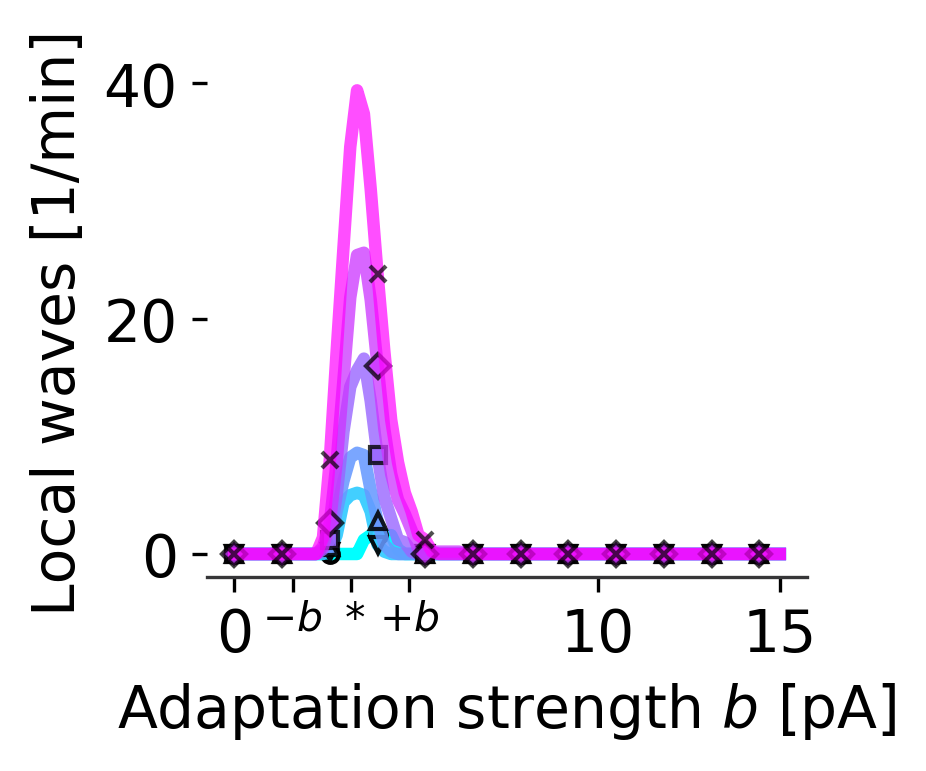

In [221]:
fig, ax = plt.subplots(figsize=(3.5,2.7))
markers = ["o", "v", "^", "s", "D", "x"]
for i, (key, grp) in enumerate(search.dfResults.groupby(['sigma_ou'])):
    color = plt.get_cmap("cool")(int(key*(255.0/0.5)))
    smooth_peaks = (grp['peaks25']-grp['peaks50']).rolling(5, min_periods=1).mean()
    ax.plot(grp['b'], smooth_peaks, c=color, marker=markers[i], markersize=4, markevery=7, markeredgecolor='k', lw=3, label="${:0.1f}$".format(key), alpha=0.93**i) #"$\sigma_{ou}="+
    #ax.plot(grp['b'], grp['down'], c='C1', marker=markers[i], markersize=4, markeredgecolor='k', lw=2)
#plt.ylim(0, 5)
#plt.legend(frameon=False, fontsize=8)
plt.xlabel("Adaptation strength $b$ [pA]")
plt.ylabel("Local waves [1/min]")
#plt.legend(fontsize=10, frameon=False, loc="upper center", bbox_to_anchor=(1.18, 0.85), ncol=1, handletextpad=0.5, labelspacing=0)
#plt.yticks([])
plt.xticks([0, 1.6, 3.2, 4.8, 10, 15], [0, "$^{-b}$", "$^*$", "$^{+b}$", 10, 15])
plt.gca().tick_params(axis="both",direction="out",bottom=True,left=True)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.tight_layout()
set_axis_size(2.0, 1.7)
plt.savefig("data/figures/RESULTS-adaptation/adaptation_local_waves.pdf", transparent=True, bbox_inches = "tight")
plt.savefig("data/figures/RESULTS-adaptation/adaptation_local_waves.svg", transparent=True, bbox_inches = "tight")

In [ ]:
## fig, ax = plt.subplots(figsize=(3.5,2.7))
markers = ["o", "v", "^", "s", "D", "x"]
for i, (key, grp) in enumerate(search.dfResults.groupby(['sigma_ou'])):
    color = plt.get_cmap("cool")(int(key*(255.0/0.5)))
    smooth_peaks = (grp['peaks50']).rolling(5, min_periods=1).mean()
    ax.plot(grp['b'], smooth_peaks, c=color, marker=markers[i], markersize=4, markevery=7, markeredgecolor='k', lw=3, label="${:0.1f}$".format(key), alpha=0.93**i) #"$\sigma_{ou}="+
    #ax.plot(grp['b'], grp['down'], c='C1', marker=markers[i], markersize=4, markeredgecolor='k', lw=2)
#plt.ylim(0, 5)
#plt.legend(frameon=False, fontsize=8)
#plt.xlabel("Adaptation strength $b$ [pA]")
plt.ylabel("Global waves [1/min]")
#plt.yticks([])
plt.tight_layout()
plt.xticks([0, 1.6, 3.2, 4.8, 10, 15], [0, "$^{-b}$", "$^*$", "$^{+b}$", 10, 15])
plt.gca().tick_params(axis="both",direction="out",bottom=True,left=True)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
set_axis_size(2.0, 1.7)
plt.savefig("data/figures/RESULTS-adaptation/adaptation_global_waves_color.pdf", transparent=True, bbox_inches = "tight")
plt.savefig("data/figures/RESULTS-adaptation/adaptation_global_waves_color.svg", transparent=True, bbox_inches = "tight")

# Oscillation ISI

Here the model is simulated and oscillations are classified into global and local. Then their ISI distribution is plotted (Fig. 4 f).

In [214]:
import scipy.signal

def peak_isi(peaks):
    return np.diff(peaks)/1000*model.params.dt

def filter_peaks(peaks, involvement, threshold_max, threshold_min = 0):
    around = int(500 / model.params.dt)
    return [p for p in peaks if (involvement[p] > threshold_min and involvement[p] <= threshold_max)]
    

def get_peaks(involvement, min_distance=1000):
    filtered_involvement = scipy.ndimage.gaussian_filter1d(involvement, 2000)
    peaks = scipy.signal.find_peaks(filtered_involvement, height=0.1, distance=min_distance)[0]

    peaks25 = filter_peaks(peaks, involvement, 0.50, 0.0)
    peaks50 = filter_peaks(peaks, involvement, 0.75, 0.50)
    peaks75 = filter_peaks(peaks, involvement, 1, 0.75)

    return peaks25, peaks50, peaks75

def plot_peaks(peaks, color='springgreen'):
    for p in peaks.copy():
        dt_min = p
        around = int(500 / model.params.dt)
        if dt_min+around < len(involvement):
            plt.scatter(dt_min/1000*model.params.dt, involvement[dt_min], color=color, s=5)
            #plt.plot(np.arange(dt_min-around, dt_min+around)/1000*model.params.dt, involvement[dt_min-around : dt_min+around], lw=1, c=color)
    

# Sleep model wave ISI

In [202]:
ds = Dataset("gw_big", fcd=False)
model = ALNModel(Cmat = ds.Cmat, Dmat = ds.Dmat)
model.params['dt'] = 0.1
model.params['duration'] = 10.0 * 60 * 1000 #ms

# Results in /mnt/raid/data/cakan/hdf/experiment-10.0-adaptation-noise.hdf
model.params["mue_ext_mean"] = 3.3202829454334535
model.params["mui_ext_mean"] = 3.682451894176651
model.params["b"] = 3.2021806735984186
model.params["tauA"] = 4765.3385276559875
model.params["sigma_ou"] = 0.36802952978628106
model.params["Ke_gl"] = 265.48075753153

MainProcess root INFO     Loading dataset gw_big from /mnt/antares_raid/home/cakan/projects/neurolib/neurolib/utils/../data/datasets/gw_big.
MainProcess root INFO     Dataset gw_big loaded.
MainProcess root INFO     aln: Model initialized.


In [ ]:
model.run()
states, durations, involvement, kuramoto_up, kuramoto_down, peaks, ups, downs = process_run(model.output)

In [215]:
peaks25, peaks50, peaks75 = get_peaks(involvement, min_distance=500)

In [217]:
print(len(peaks25))
print(len(peaks50))
print(len(peaks75))

202
110
76


We collect all peaks from 25-75 into one group (local oscillations)

(0, 100)

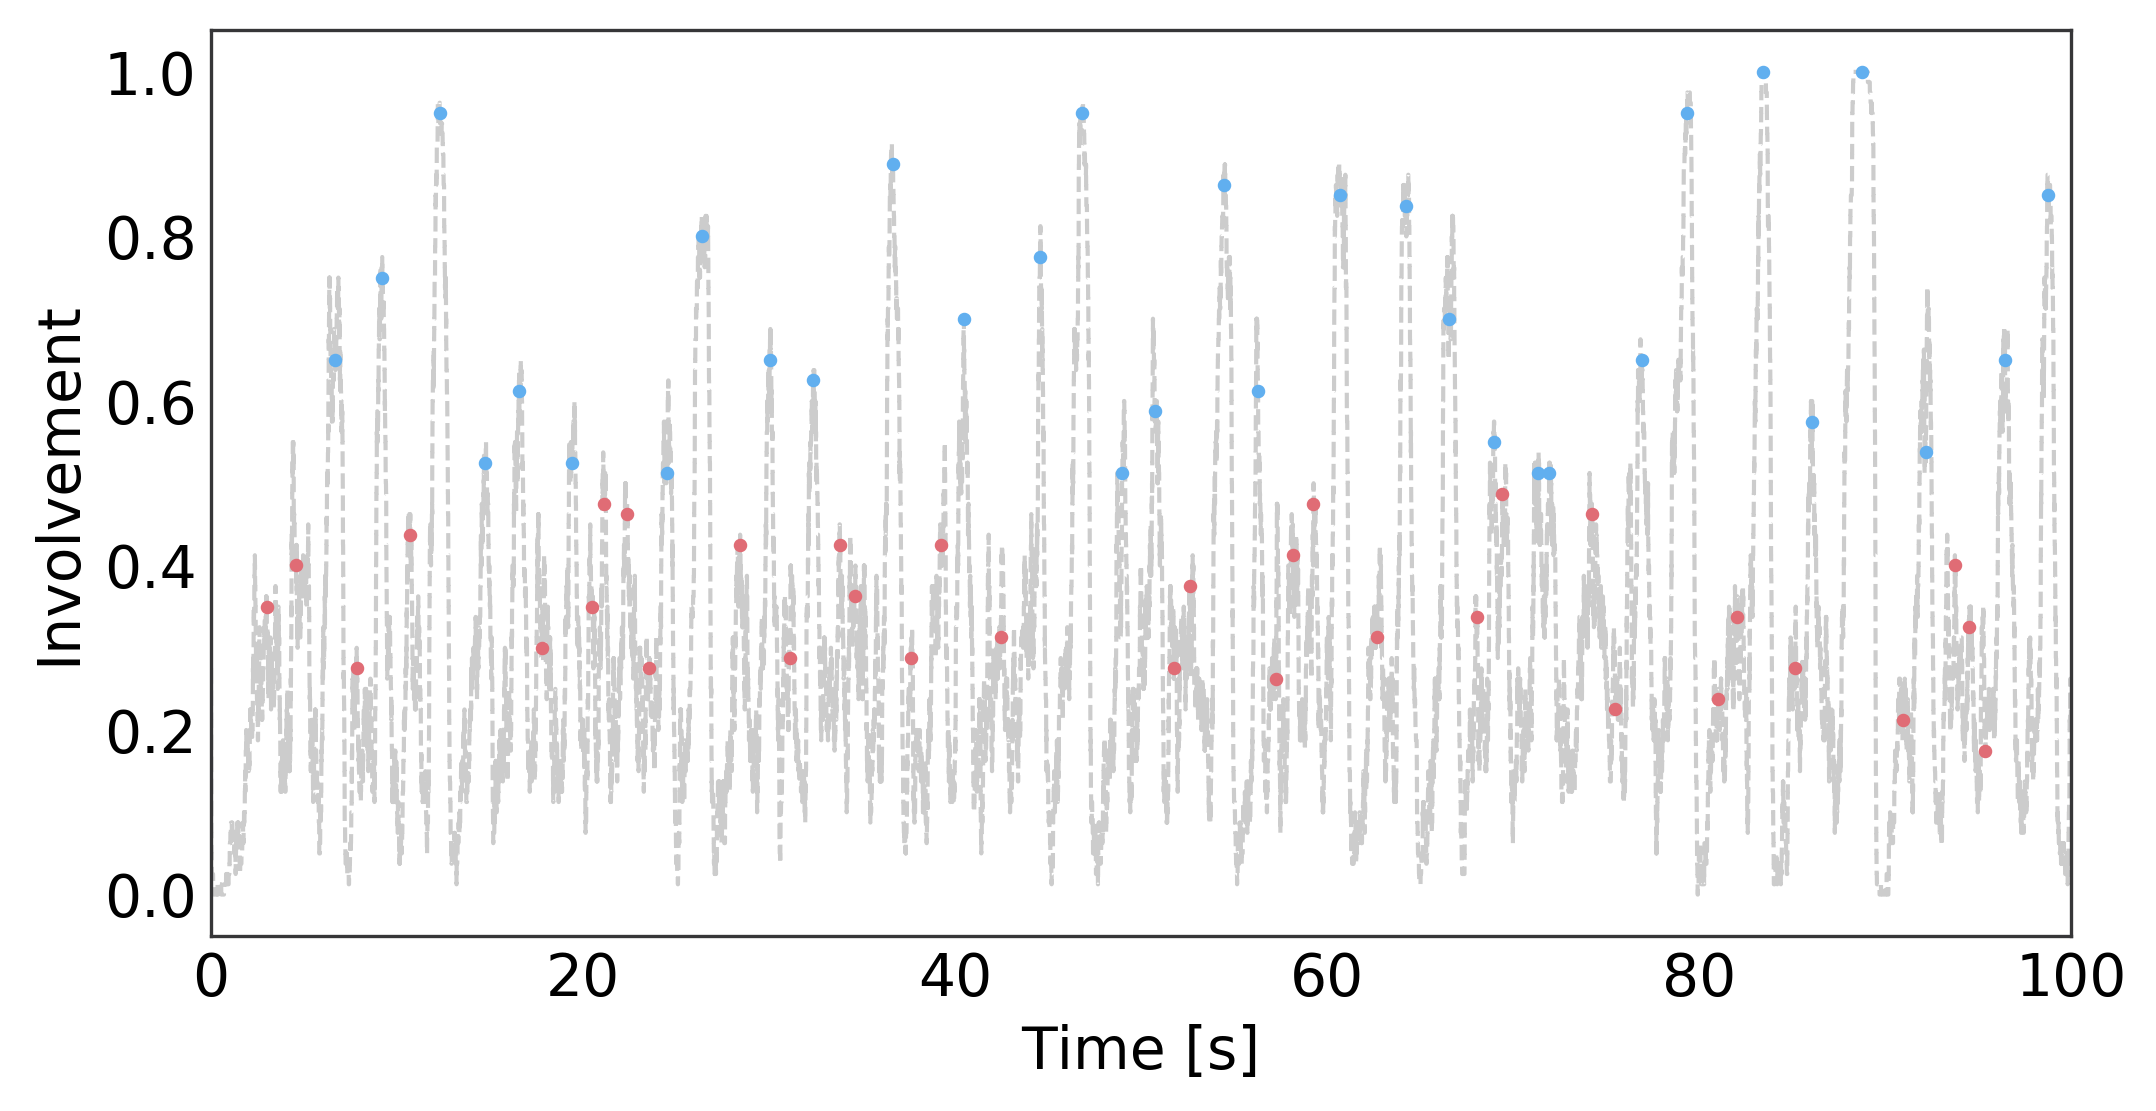

In [206]:
plot_peaks(peaks25, "C0")
plot_peaks(peaks50, "C1")
plot_peaks(peaks75, "C1")
plt.plot(model.t/1000, involvement, c='k', zorder=-2, ls="--", lw=1, alpha=0.2)
plt.xlabel("Time [s]")
plt.ylabel("Involvement")
plt.xlim(0, 100)
#plt.savefig("data/figures/RESULTS-adaptation/global_local_waves_timeseries.pdf", transparent=True)
#plt.savefig("data/figures/RESULTS-adaptation/global_local_waves_timeseries.svg", transparent=True)

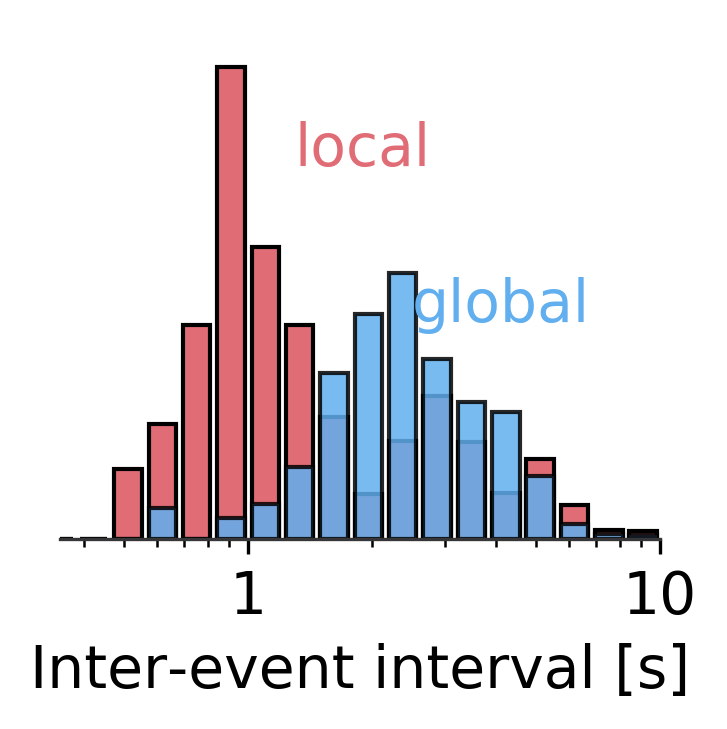

In [218]:
figsize=(2, 1.7)
plt.figure(figsize=figsize)
nbins = 25
#plt.hist(all_peak50_isis,alpha=0.75, bins=10**(np.linspace(0,1,nbins)), density=True)
plt.hist(peak_isi(peaks25), rwidth=0.8, edgecolor="k", alpha=1, bins=10**(np.linspace(-1,1,nbins)), density=True, label='Local', color='C0')
plt.hist(peak_isi(np.sort(peaks50 + peaks75).tolist()), rwidth=0.8, edgecolor="k", alpha=0.85, bins=10**(np.linspace(-1,1,nbins)), density=True, label='Global', color='C1')
#plt.legend()
plt.gca().tick_params(axis="both",direction="out",bottom=True,left=True)
plt.xlim(0.35, 10)
plt.xscale('log')
plt.yticks([0, 0.25, 0.5, 0.75], [0, 25, 50, 75])
plt.xticks([1, 10], [1, 10])
plt.text(1.3, 0.55, "local", fontsize=14,  color='C0')
plt.text(2.5, 0.32, "global", fontsize=14,  color='C1')
plt.xlabel("Inter-event interval [s]")
plt.yticks([])
#plt.ylabel("Probability")

ax = plt.gca()
import matplotlib.ticker
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=np.arange(2, 10) * .1, numticks=20)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
plt.gca().tick_params(axis="x",direction="out",which='minor',bottom=True,left=True)

plt.tight_layout()

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
#ax.spines["bottom"].set_visible(False)

set_axis_size(*figsize)
#plt.savefig("data/figures/RESULTS-adaptation/global_local_waves_isi.pdf", transparent=True, bbox_inches = "tight")
#plt.savefig("data/figures/RESULTS-adaptation/global_local_waves_isi.svg", transparent=True, bbox_inches = "tight")